In [1]:
import cv2
import os
from matplotlib import pyplot as plt
from pyzbar.pyzbar import decode
import shutil
import glob
from skimage import metrics
import numpy as np
import pandas as pd

%matplotlib inline

In [ ]:
## One way of extracting frames from video

filepath = "/home/lei/data/pipeline/color_vaapi_0.mp4"
# filepath = "/home/lei/data/pipeline/color_nvenc_0.mp4"
cap = cv2.VideoCapture(filepath)
while not cap.isOpened():
    cap = cv2.VideoCapture(filepath)
    cv2.waitKey(1000)
    print("Wait for the header")

pos_frame = cap.get(cv2.CAP_PROP_POS_FRAMES)
while True:
    flag, frame = cap.read()
    if flag:
        # The frame is ready and already captured
        # cv2.imshow('video', frame)
        pos_frame = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        print(str(pos_frame)+" frame")
        # cv2.imwrite('/home/lei/data/pipeline/color_vaapi_0/frame_'+str(pos_frame)+'.png', frame)
        cv2.imwrite('/home/lei/data/pipeline/color_nvenc_0/frame_'+str(pos_frame)+'.png', frame)
    else:
        # The next frame is not ready, so we try to read it again
        cap.set(cv2.CAP_PROP_POS_FRAMES, pos_frame-1)
        print("frame is not ready")
        # It is better to wait for a while for the next frame to be ready
        cv2.waitKey(1000)

    if cv2.waitKey(10) == 27:
        break
    if cap.get(cv2.CAP_PROP_POS_FRAMES) == cap.get(cv2.CAP_PROP_FRAME_COUNT):
        # If the number of captured frames is equal to the total number of frames,
        # we stop
        break

In [2]:
def decode_qr_code(image, offset_x=20, offset_y=20, roi_width=82, roi_height=82):
    # Extract the region of interest (ROI) based on the offset and size
    if roi_width and roi_height:
        roi = image[offset_y:offset_y+roi_height, offset_x:offset_x+roi_width]
    else:
        roi = image

    # Convert the ROI to grayscale
    gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

    # Use pyzbar to decode the QR code
    qr_codes = decode(gray_roi)

    if qr_codes:
        # There may be multiple QR codes in the ROI, but we'll handle just the first one for this example
        qr_code_data = qr_codes[0].data.decode('utf-8')
        # print("Decoded QR Code data:", qr_code_data)
        return int(qr_code_data)
    else:
        # print("No QR Code detected in the ROI.")
        return -1

In [4]:
## Another way of extracting frames from video - Currently used

# filepath = "/home/lei/data/pipeline/color_vaapi_0.mp4"
bitrate = ["100000k", "200000k"]
preset = ""
# preset = "hq"

qp = ""
# qp = "0"
# qp = "50"

loss = ""
# loss = "lossless"

params = ""
if preset:
    params += "_{}".format(preset)

if qp:
    params += "_qp_{}".format(qp)
    
if loss:
    params += "_{}".format(loss)

# video_names = ["color_nvenc_{}{}_c".format(bitrate[0], params), "depth_nvenc_{}{}_d_yuv16".format(bitrate[1], params)]
video_names = ["color_nvenc_{}{}_c".format(bitrate[0], params)]
input_path = "/home/lei/data/pipeline/server_standalone/pipeline_new/160317_moonbaby1_no_ground/"
output_path = os.path.join(input_path, "nvenc_c_{}_d_yuv16_{}".format(bitrate[0], bitrate[1], params))
if os.path.exists(output_path):
    shutil.rmtree(output_path)
os.makedirs(os.path.join(output_path, "color"))
os.makedirs(os.path.join(output_path, "depth"))
# os.makedirs(os.path.join(output_path, "binary_mask"))


filepath = [os.path.join(input_path, "{}.mp4".format(v)) for v in video_names]
for file in filepath:
    prev_frame_id = -1
    if not os.path.exists(file):
        print("File {} does not exist".format(file))
        exit(0)
    
    cap = cv2.VideoCapture(file)
    while cap.isOpened():
        ret, frame = cap.read()
        if ret == False:
            break
        
        frame_id = decode_qr_code(frame)
        if frame_id != -1:
            assert frame_id > prev_frame_id, "frame_id: {}, prev_frame_id: {}".format(frame_id, prev_frame_id) # Check if the frame id is increasing, sanity check
            prev_frame_id = frame_id
            if "color" in file:
                outfile = os.path.join(output_path, "color", "{}_color.png".format(frame_id))
            elif "depth" in file:
                outfile = os.path.join(output_path, "depth", "{}_depth.png".format(frame_id))
            else:
                print("File {} is not color or depth".format(file))
                exit(0)
            
            cv2.imwrite(outfile, frame)
            
            w = 592
            h = 512
            views = []
            for i in range(5):
                views.append(frame[0:h, i*w:(i+1)*w])
            for i in range(5):
                views.append(frame[h:h*2, i*w:(i+1)*w])
            
            for i, view in enumerate(views):
                if "color" in file:
                    outfile = os.path.join(output_path, "color", "{}_color_{}.png".format(frame_id, i))
                elif "depth" in file:
                    outfile = os.path.join(output_path, "depth", "{}_depth_{}.png".format(frame_id, i))
                view = cv2.cvtColor(view, cv2.COLOR_BGR2BGRA)
                cv2.imwrite(outfile, view)
        else:
            print("WARNING: Frame id not found")
            
        # cv2.imwrite("/home/lei/data/pipeline/color_vaapi_0/frameb_%d.jpg" % count, frame)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
        if cap.get(cv2.CAP_PROP_POS_FRAMES) == cap.get(cv2.CAP_PROP_FRAME_COUNT):
            # If the number of captured frames is equal to the total number of frames,
            # we stop
            break
        if frame_id % 100 == 0:
            print(frame_id)
    cap.release()

for file in glob.glob(os.path.join("/home/lei/data/KinectStream/panoptic_captures/160317_moonbaby1_no_ground/","*.txt")):
    shutil.copy2(file, output_path)
    
# print("Copy binary masks...")
# for file in glob.glob(os.path.join("/home/lei/data/KinectStream/panoptic_captures/160317_moonbaby1_scaled/","binary_mask", "*_binary_mask_*.png")):
#     shutil.copy2(file, os.path.join(output_path, "binary_mask"))

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


In [ ]:
img = cv2.imread("/home/lei/data/pipeline/server_standalone/nvenc_10k_20k/59_depth_0.png", cv2.IMREAD_UNCHANGED)
print(img.shape)
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

In [ ]:
# Copy compressed color images
src = "/home/lei/data/pipeline/server_standalone/160317_moonbaby1_clean/nvenc_10k_20k/"
dst = "/home/lei/data/pipeline/server_standalone/160317_moonbaby1_clean/nvenc_10k_infinite/"

if not os.path.exists(dst):
    os.makedirs(dst)

for file in glob.glob(os.path.join(src,"*.txt")):
    shutil.copy2(file, dst)

start_frameID = 59
end_frameID = 2500

for frameID in range(start_frameID, end_frameID):
    for view in range(10):
        srcfile = os.path.join(src, "{}_color_{}.png".format(frameID, view))
        if not os.path.exists(srcfile):
            continue
        dstfile = os.path.join(dst, "{}_color_{}.png".format(frameID, view))
        shutil.copyfile(srcfile, dstfile)
    if frameID % 100 == 0:
        print("Frame color {} done".format(frameID))

## Copy ground truth depth images - No loss in depth stream

src = "/home/lei/data/KinectStream/panoptic_captures/160317_moonbaby1_clean/"

for frameID in range(start_frameID, end_frameID):
    for view in range(10):
        srcfile = os.path.join(src, "{}_depth_{}.png".format(frameID, view))
        if not os.path.exists(srcfile):
            continue
        dstfile = os.path.join(dst, "{}_depth_{}.png".format(frameID, view))
        shutil.copyfile(srcfile, dstfile)
    if frameID % 100 == 0:
        print("Frame depth {} done".format(frameID))
    
print("Copy binary images...")
for file in glob.glob(os.path.join(src,"*_binary_mask_*.png")):
    shutil.copy2(file, dst)

In [4]:
## Customized copy of extracted frames - copy the depth frames from custom decoded video, while copy the color frames from decoded video (at higher bitrate)

src = "/home/lei/data/KinectStream/panoptic_captures/160317_moonbaby1_scaled/"
dst = "/home/lei/data/pipeline/server_standalone/160317_moonbaby1_scaled/nvenc_10000k_d_yuv16/"

if not os.path.exists(dst):
    os.makedirs(dst)

for file in glob.glob(os.path.join(src,"*.txt")):
    shutil.copy2(file, dst)

src = "/home/lei/data/KinectStream/panoptic_captures/160317_moonbaby1_scaled/color/"
dst = "/home/lei/data/pipeline/server_standalone/160317_moonbaby1_scaled/nvenc_10000k_d_yuv16/color/"

if not os.path.exists(dst):
    os.makedirs(dst)

start_frameID = 59
end_frameID = 2000

for frameID in range(start_frameID, end_frameID):
    for view in range(10):
        srcfile = os.path.join(src, "{}_color_{}.png".format(frameID, view))
        if not os.path.exists(srcfile):
            continue
        dstfile = os.path.join(dst, "{}_color_{}.png".format(frameID, view))
        shutil.copyfile(srcfile, dstfile)
    if frameID % 100 == 0:
        print("Frame color {} done".format(frameID))

# src = "/home/lei/data/pipeline/server_standalone/160317_moonbaby1_scaled/depth_quantized/"
src = "/home/lei/data/pipeline/client_standalone/160317_moonbaby1_scaled/depth_nvenc_10000k_d_yuv16/"
dst = "/home/lei/data/pipeline/server_standalone/160317_moonbaby1_scaled/nvenc_10000k_d_yuv16/depth/"
if not os.path.exists(dst):
    os.makedirs(dst)

prev_frameID = 59
for frameID in range(start_frameID, end_frameID):
    for view in range(10):
        srcfile = os.path.join(src, "{}_depth_{}.png".format(frameID, view))
        # if not os.path.exists(srcfile):
        #     srcfile = os.path.join(src, "{}_depth_{}.png".format(prev_frameID, view))
        if not os.path.exists(srcfile):
            continue
        dstfile = os.path.join(dst, "{}_depth_{}.png".format(frameID, view))
        shutil.copyfile(srcfile, dstfile)
    prev_frameID = frameID
    
    if frameID % 100 == 0:
        print("Frame depth {} done".format(frameID))

dst = "/home/lei/data/pipeline/server_standalone/160317_moonbaby1_scaled/nvenc_10000k_d_yuv16/binary_mask/"
if not os.path.exists(dst):
    os.makedirs(dst)

print("Copy binary images...")
for file in glob.glob(os.path.join("/home/lei/data/KinectStream/panoptic_captures/160317_moonbaby1_scaled/binary_mask/","*_binary_mask_*.png")):
    shutil.copy2(file, dst)

Frame color 100 done
Frame color 200 done
Frame color 300 done
Frame color 400 done
Frame color 500 done
Frame color 600 done
Frame color 700 done
Frame color 800 done
Frame color 900 done
Frame color 1000 done
Frame color 1100 done
Frame color 1200 done
Frame color 1300 done
Frame color 1400 done
Frame color 1500 done
Frame color 1600 done
Frame color 1700 done
Frame color 1800 done
Frame color 1900 done
Frame depth 100 done
Frame depth 200 done
Frame depth 300 done
Frame depth 400 done
Frame depth 500 done
Frame depth 600 done
Frame depth 700 done
Frame depth 800 done
Frame depth 900 done
Frame depth 1000 done
Frame depth 1100 done
Frame depth 1200 done
Frame depth 1300 done
Frame depth 1400 done
Frame depth 1500 done
Frame depth 1600 done
Frame depth 1700 done
Frame depth 1800 done
Frame depth 1900 done
Copy binary images...


In [ ]:
## Customized copy of extracted frames - median filter on depth frames, while copy the color frames from decoded video (at higher bitrate)

FILTER_SIZE = 3

src = "/home/lei/data/pipeline/server_standalone/160317_moonbaby1_clean/nvenc_10k_20k/"
dst = "/home/lei/data/pipeline/server_standalone/160317_moonbaby1_clean/nvenc_10k_quantized_mfilter_{}/".format(FILTER_SIZE) # mfilter: median filter

if not os.path.exists(dst):
    os.makedirs(dst)

for file in glob.glob(os.path.join(src,"*.txt")):
    shutil.copy2(file, dst)

start_frameID = 59
end_frameID = 2500

for frameID in range(start_frameID, end_frameID):
    for view in range(10):
        srcfile = os.path.join(src, "{}_color_{}.png".format(frameID, view))
        if not os.path.exists(srcfile):
            continue
        dstfile = os.path.join(dst, "{}_color_{}.png".format(frameID, view))
        shutil.copyfile(srcfile, dstfile)
    if frameID % 100 == 0:
        print("Frame color {} done".format(frameID))

# Apply median filter to depth images
src = "/home/lei/data/pipeline/server_standalone/160317_moonbaby1_clean/depth_quantized/"
dst = "/home/lei/data/pipeline/server_standalone/160317_moonbaby1_clean/nvenc_10k_quantized_mfilter_{}/".format(FILTER_SIZE)   # mfilter: median filter

qr_offset_x = 20
qr_offset_y = 20
qr_width = 82
qr_height = 82

for frameID in range(start_frameID, end_frameID):
    for view in range(10):
        srcfile = os.path.join(src, "{}_depth_{}.png".format(frameID, view))
        if not os.path.exists(srcfile):
            continue
        
        img = cv2.imread(srcfile, cv2.IMREAD_UNCHANGED)
        roi = np.copy(img[qr_offset_y:qr_offset_y+qr_height, qr_offset_x:qr_offset_x+qr_width])
        img = cv2.medianBlur(img, FILTER_SIZE)
        img[qr_offset_y:qr_offset_y+qr_height, qr_offset_x:qr_offset_x+qr_width] = roi
        
        dstfile = os.path.join(dst, "{}_depth_{}.png".format(frameID, view))
        cv2.imwrite(dstfile, img)
    
    if frameID % 100 == 0:
        print("Frame depth {} done".format(frameID))
    
print("Copy binary images...")
for file in glob.glob(os.path.join("/home/lei/data/KinectStream/panoptic_captures/160317_moonbaby1_clean/","*_binary_mask_*.png")):
    shutil.copy2(file, dst)

In [4]:
# Input images are color images

def ssim_psnr_rmse(img1, img2, multi_channel=False):
    with_alpha = False
    assert(img1.shape == img2.shape)
    if img1.shape[2] == 4:
        with_alpha = True
    
    if not multi_channel:
        if not with_alpha:
            img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
            img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        else:
            img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGRA2GRAY)
            img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGRA2GRAY)
        ssim, diff = metrics.structural_similarity(img1_gray, img2_gray, full=True)
        psnr = metrics.peak_signal_noise_ratio(img1_gray, img2_gray)
        if(np.isinf(psnr)):
            psnr = 100.0
        rmse = np.sqrt(metrics.mean_squared_error(img1_gray, img2_gray))
        
    else:
        if not with_alpha:
            img1_color = cv2.cvtColor(img1, cv2.COLOR_BGRA2BGR)
            img2_color = cv2.cvtColor(img2, cv2.COLOR_BGRA2BGR)
        ssim, diff = metrics.structural_similarity(img1_color, img2_color, full=True, multichannel=True)
        psnr = metrics.peak_signal_noise_ratio(img1_color, img2_color)
        if(np.isinf(psnr)):
            psnr = 100.0
        rmse = np.sqrt(metrics.mean_squared_error(img1_color, img2_color))
    
    return ssim, psnr, rmse, diff
        

In [ ]:
# Measured SSIM, PSNR, RMSE metrics between ground truth and decoded images
gt_color_path = '/home/lei/data/KinectStream/panoptic_captures/160317_moonbaby1_clean/'
gt_depth_path = '/home/lei/data/pipeline/server_standalone/160317_moonbaby1_clean/depth_quantized/'

rf_color_path = '/home/lei/data/pipeline/server_standalone/160317_moonbaby1_clean/nvenc_10k_20k/'
rf_depth_path = '/home/lei/data/pipeline/server_standalone/160317_moonbaby1_clean/nvenc_10k_20k/'

avg_color_ssim = []
avg_color_psnr = []
avg_color_rmse = []

avg_depth_ssim = []
avg_depth_psnr = []
avg_depth_rmse = []

valid_frameID = []

start_frameID = 200
end_frameID = 1000

for frameID in range(start_frameID, end_frameID):
    color_ssim = []
    color_psnr = []
    color_rmse = []
    
    depth_ssim = []
    depth_psnr = []
    depth_rmse = []
    
    for view in range(10):
        gt_color_img = cv2.imread(os.path.join(gt_color_path, "{}_color_{}.png".format(frameID, view)), cv2.IMREAD_UNCHANGED)
        rf_color_img = cv2.imread(os.path.join(rf_color_path, "{}_color_{}.png".format(frameID, view)), cv2.IMREAD_UNCHANGED)
        if gt_color_img is None or rf_color_img is None:
            continue
        ssim_color, psnr_color, rmse_color, diff_color = ssim_psnr_rmse(gt_color_img, rf_color_img, multi_channel=False)
        
        gt_depth_img = cv2.imread(os.path.join(gt_depth_path, "{}_depth_{}.png".format(frameID, view)), cv2.IMREAD_UNCHANGED)
        rf_depth_img = cv2.imread(os.path.join(rf_depth_path, "{}_depth_{}.png".format(frameID, view)), cv2.IMREAD_UNCHANGED)
        if gt_depth_img is None or rf_depth_img is None:
            continue
        ssim_depth, psnr_depth, rmse_depth, diff_depth = ssim_psnr_rmse(gt_depth_img, rf_depth_img, multi_channel=False)
        
        color_ssim.append(ssim_color)
        color_psnr.append(psnr_color)
        color_rmse.append(rmse_color)

        depth_ssim.append(ssim_depth)
        depth_psnr.append(psnr_depth)
        depth_rmse.append(rmse_depth)
    
    if len(color_ssim) < 10 or len(depth_ssim) < 10:
        continue
    
    avg_color_ssim.append(np.mean(color_ssim))
    avg_color_psnr.append(np.mean(color_psnr))
    avg_color_rmse.append(np.mean(color_rmse))
    
    avg_depth_ssim.append(np.mean(depth_ssim))
    avg_depth_psnr.append(np.mean(depth_psnr))
    avg_depth_rmse.append(np.mean(depth_rmse))
    
    valid_frameID.append(frameID)
    print("COLOR: ", frameID, "AVG SSIM: {:.3f}".format(avg_color_ssim[-1] * 100), ", AVG PSNR: {:.2f}".format(avg_color_psnr[-1]), ", AVG RMSE: {:.2f}".format(avg_color_rmse[-1]))
    print("DEPTH: ", frameID, "AVG SSIM: {:.3f}".format(avg_depth_ssim[-1] * 100), ", AVG PSNR: {:.2f}".format(avg_depth_psnr[-1]), ", AVG RMSE: {:.2f}".format(avg_depth_rmse[-1]))

print("COLOR: ", "AVG SSIM: {:.3f}".format(np.mean(avg_color_ssim) * 100), ", AVG PSNR: {:.2f}".format(np.mean(avg_color_psnr)), ", AVG RMSE: {:.2f}".format(np.mean(avg_color_rmse)))
print("DEPTH: ", "AVG SSIM: {:.3f}".format(np.mean(avg_depth_ssim) * 100), ", AVG PSNR: {:.2f}".format(np.mean(avg_depth_psnr)), ", AVG RMSE: {:.2f}".format(np.mean(avg_depth_rmse)))

In [8]:
## Measure SSIM, PSNR, RMSE metrics between ground truth and reference images from ptcl rendering

color_bitrate = 10000
depth_bitrate = 20000
binary_mask = ""

# binary_mask = "_binary_mask"

# exp_name = f'o3d_nvenc_{color_bitrate}k_{depth_bitrate}k_d_yuv16'

# # ZSTD
# compression_level = 1       # Ptcl compression level
# exp_name = f'o3d_zstd_cl{compression_level}'

# DRACO
cl = 0
qp = 8
exp_name = f'o3d_draco_cl{cl}_qp{qp}'

base_path = '/home/lei/data/pipeline/client_standalone/pipeline_new/160317_moonbaby1_no_ground/'
gt_path = os.path.join(base_path, 'o3d_gt')
rf_path = os.path.join(base_path, exp_name)
# rf_path2 = os.path.join(base_path, 'o3d_nvenc_10000k_20000k_d_yuv16_gt')

comp_path = os.path.join(base_path, f'comp_o3d_images/{exp_name}')
diff_path = os.path.join(base_path, f'diff_o3d_images/{exp_name}')

# if os.path.exists(comp_path):
#     shutil.rmtree(comp_path)
if not os.path.exists(comp_path):
    os.makedirs(comp_path)

if os.path.exists(diff_path):
    shutil.rmtree(diff_path)
os.makedirs(diff_path)

out_file_path = os.path.join(comp_path, "2D_metrics.txt")
if os.path.exists(out_file_path):
    os.remove(out_file_path)
metrics_file = open(out_file_path, "w")

avg_ssim_gray = 0.0
avg_psnr_gray = 0.0
avg_rmse_gray = 0.0

avg_psnr_gray2 = 0.0
avg_ssim_gray2 = 0.0
avg_rmse_gray2 = 0.0

ssim_gray = []
psnr_gray = []
rmse_gray = []

ssim_gray2 = []
psnr_gray2 = []
rmse_gray2 = []

ssim_color = []
psnr_color = []
rmse_color = []

ssim_color2 = []
psnr_color2 = []
rmse_color2 = []

for id in range(70, 2000):
    score_ssim = 0
    score_psnr = 0
    score_rmse = 0
    
    gt_name = os.path.join(gt_path, str(id) + '.png')
    rf_name = os.path.join(rf_path, str(id) + '.png')
    # rf_name2 = os.path.join(rf_path2, str(id) + '.png')
    comp_name = os.path.join(comp_path, str(id) + '.png')
    diff_name = os.path.join(diff_path, str(id) + '.png')
    
    if not os.path.exists(gt_name) or not os.path.exists(rf_name):
        continue
    
    gt = cv2.imread(gt_name)
    rf = cv2.imread(rf_name)
    # rf2 = cv2.imread(rf_name2)
    
    # gt_gray = cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY)
    # rf_gray = cv2.cvtColor(rf, cv2.COLOR_BGR2GRAY)
    # rf_gray2 = cv2.cvtColor(rf2, cv2.COLOR_BGR2GRAY)
    
    # score_ssim_gray, diff_gray = structural_similarity(gt_gray, rf_gray, full=True)
    # score_psnr_gray = peak_signal_noise_ratio(gt_gray, rf_gray)
    # score_rmse_gray = (gt_gray, rf_gray)
    
    # score_ssim_gray2, diff_gray2 = structural_similarity(gt_gray, rf_gray2, full=True)
    # score_psnr_gray2 = peak_signal_noise_ratio(gt_gray, rf_gray2)
    # score_rmse_gray2 = normalized_root_mse(gt_gray, rf_gray2)

    # metrics in gray scale
    score_ssim_gray, score_psnr_gray, score_rmse_gray, diff_gray = ssim_psnr_rmse(gt, rf)
    # score_ssim_gray2, score_psnr_gray2, score_rmse_gray2, diff_gray2 = ssim_psnr_rmse(gt, rf2)
    
    ssim_gray.append(score_ssim_gray)
    psnr_gray.append(score_psnr_gray)
    rmse_gray.append(score_rmse_gray)
    
    avg_ssim_gray = np.mean(ssim_gray)
    avg_psnr_gray = np.mean(psnr_gray)
    avg_rmse_gray = np.mean(rmse_gray)
    
    # ssim_gray2.append(score_ssim_gray2)
    # psnr_gray2.append(score_psnr_gray2)
    # rmse_gray2.append(score_rmse_gray2)
    
    # avg_ssim_gray2 = np.mean(ssim_gray2)
    # avg_psnr_gray2 = np.mean(psnr_gray2)
    # avg_rmse_gray2 = np.mean(rmse_gray2)
    
    # # metrics in color
    # score_ssim_color, score_psnr_color, score_rmse_color, diff_color = ssim_psnr_rmse(gt, rf, multi_channel=True)
    # score_ssim_color2, score_psnr_color2, score_rmse_color2, diff_color2 = ssim_psnr_rmse(gt, rf2, multi_channel=True)
    
    # ssim_color.append(score_ssim_color)
    # psnr_color.append(score_psnr_color)
    # rmse_color.append(score_rmse_color)
    
    # score_ssim_color, diff_color = structural_similarity(gt, rf, full=True, multichannel=True)
    # score_psnr_color = peak_signal_noise_ratio(gt, rf)
    # score_rmse_color = normalized_root_mse(gt, rf)
    
    # count += 1
    # avg_ssim_gray = (avg_ssim_gray*(count - 1) + score_ssim_gray)/count
    # avg_psnr_gray = (avg_psnr_gray*(count - 1) + score_psnr_gray)/count
    
    # avg_ssim_gray2 = (avg_ssim_gray2*(count - 1) + score_ssim_gray2)/count
    # avg_psnr_gray2 = (avg_psnr_gray2*(count - 1) + score_psnr_gray2)/count
    
    print("-----------------------------------------------------")
    print(f"{id}, SSIM_gray: {score_ssim_gray * 100.0:.2f}, PSNR_gray: {score_psnr_gray:.2f}, RMSE_gray: {score_rmse_gray:.2f}")
    # print(id, "SSIM_gray2: {:.3f}".format(score_ssim_gray2 * 100), ", PSNR_gray2: {:.2f}".format(score_psnr_gray2), ", RMSE_gray2: {:.2f}".format(score_rmse_gray2))
    # print(id, "SSIM_color: {:.3f}".format(score_ssim_color * 100), ", PSNR_color: {:.2f}".format(score_psnr_color),  ", RMSE_color: {:.2f}".format(score_rmse_color))

    print(f"{id}, AVG_SSIM_gray: {avg_ssim_gray * 100.0:.2f}, AVG_PSNR_gray: {avg_psnr_gray:.2f}, AVG_RMSE_gray: {avg_rmse_gray:.2f}")
    # print(id, "AVG SSIM_gray2: {:.3f}".format(avg_ssim_gray2 * 100), ", AVG PSNR_gray2: {:.2f}".format(avg_psnr_gray2), ", AVG RMSE_gray2: {:.2f}".format(avg_rmse_gray2))

    metrics_file.write(f"{id}, SSIM_gray: {score_ssim_gray * 100.0:.2f}, AVG_SSIM_gray: {avg_ssim_gray * 100.0:.2f}, PSNR_gray: {score_psnr_gray:.2f}, AVG_PSNR_gray: {avg_psnr_gray:.2f}, RMSE_gray: {score_rmse_gray:.2f}\n")
    
    if id % 100 == 0:
        vis = np.concatenate((gt, rf), axis=1)
        cv2.imwrite(comp_name, vis)

    # vis = np.concatenate((gt, rf, rf2), axis=1)
    # cv2.imwrite(comp_name, vis)
    
    # diff = np.concatenate((diff_gray, diff_gray2), axis=1)
    # cv2.imwrite(diff_name, diff)

# Statistics
print("-----------------------------------------------------")
metrics_file.write("-----------------------------------------------------\n")
avg_ssim_gray = np.mean(ssim_gray)
avg_psnr_gray = np.mean(psnr_gray)
avg_rmse_gray = np.mean(rmse_gray)
median_ssim_gray = np.median(ssim_gray)
median_psnr_gray = np.median(psnr_gray)
median_rmse_gray = np.median(rmse_gray)

print("AVG SSIM_gray: {:.3f}".format(avg_ssim_gray * 100), ", AVG PSNR_gray: {:.2f}".format(avg_psnr_gray), ", AVG RMSE_gray: {:.2f}".format(avg_rmse_gray))
print("MEDIAN SSIM_gray: {:.3f}".format(median_ssim_gray * 100), ", MEDIAN PSNR_gray: {:.2f}".format(median_psnr_gray), ", MEDIAN RMSE_gray: {:.2f}".format(median_rmse_gray))

metrics_file.write("AVG SSIM_gray: {:.3f}".format(avg_ssim_gray * 100) + ", AVG PSNR_gray: {:.2f}".format(avg_psnr_gray) + ", AVG RMSE_gray: {:.2f}".format(avg_rmse_gray) + "\n")
metrics_file.write("MEDIAN SSIM_gray: {:.3f}".format(median_ssim_gray * 100) + ", MEDIAN PSNR_gray: {:.2f}".format(median_psnr_gray) + ", MEDIAN RMSE_gray: {:.2f}".format(median_rmse_gray) + "\n")

metrics_file.flush()
metrics_file.close()

-----------------------------------------------------
70, SSIM_gray: 82.47, PSNR_gray: 17.43, RMSE_gray: 34.28
70, AVG_SSIM_gray: 82.47, AVG_PSNR_gray: 17.43, AVG_RMSE_gray: 34.28
-----------------------------------------------------
71, SSIM_gray: 82.08, PSNR_gray: 17.26, RMSE_gray: 34.96
71, AVG_SSIM_gray: 82.27, AVG_PSNR_gray: 17.34, AVG_RMSE_gray: 34.62
-----------------------------------------------------
72, SSIM_gray: 82.02, PSNR_gray: 17.09, RMSE_gray: 35.63
72, AVG_SSIM_gray: 82.19, AVG_PSNR_gray: 17.26, AVG_RMSE_gray: 34.96
-----------------------------------------------------
73, SSIM_gray: 79.34, PSNR_gray: 16.06, RMSE_gray: 40.12
73, AVG_SSIM_gray: 81.48, AVG_PSNR_gray: 16.96, AVG_RMSE_gray: 36.25
-----------------------------------------------------
74, SSIM_gray: 79.63, PSNR_gray: 16.17, RMSE_gray: 39.65
74, AVG_SSIM_gray: 81.11, AVG_PSNR_gray: 16.80, AVG_RMSE_gray: 36.93
-----------------------------------------------------
75, SSIM_gray: 77.96, PSNR_gray: 15.63, RMSE_g

In [ ]:
img = cv2.imread("/home/lei/data/KinectStream/panoptic_captures/160317_moonbaby1/59_color_0.png", cv2.IMREAD_UNCHANGED)
img.shape

In [ ]:
img = cv2.imread("/home/lei/data/pipeline/server_standalone/nvenc_10k_jpeg/59_depth_0.jpg", cv2.IMREAD_UNCHANGED)
img.shape

In [ ]:
outpath = "/home/lei/data/pipeline/server_standalone/nvenc_10k_jpeg_1/"

if not os.path.exists(outpath):
    os.makedirs(outpath)

print("Copy color images...")
for file in glob.glob(os.path.join("/home/lei/data/pipeline/server_standalone/nvenc_10k_20k/","*_color_*.png")):
    shutil.copy2(file, outpath)

print("Saving depth images...")
depth_path = "/home/lei/data/pipeline/server_standalone/depth_quantized/"
depth_path = [os.path.join(depth_path, p) for p in os.listdir(depth_path)]
for fpath in depth_path:
    img = cv2.imread(fpath, cv2.IMREAD_UNCHANGED)
    out_fname = os.path.basename(fpath).split(".")[0] + ".jpg"
    cv2.imwrite(os.path.join(outpath, out_fname), img, [int(cv2.IMWRITE_JPEG_QUALITY), 1])

for file in glob.glob(os.path.join("/home/lei/data/KinectStream/panoptic_captures/160317_moonbaby1","*.txt")):
    shutil.copy2(file, outpath)

In [ ]:
depth_path = "/home/lei/data/pipeline/server_standalone/depth_quantized/"
[os.path.join(depth_path, p) for p in os.listdir(depth_path)]

In [ ]:
img = cv2.imread("/home/lei/data/KinectStream/panoptic_captures/160317_moonbaby1/59_color_0.png", cv2.IMREAD_UNCHANGED)
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

In [ ]:
img = cv2.imread("/home/lei/data/KinectStream/panoptic_captures/160317_moonbaby1/59_binary_mask_0.png", cv2.IMREAD_GRAYSCALE)
# image_rgb = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
outpath = "/home/lei/data/pipeline/server_standalone/nvenc_10k_jpeg_100/"

print("Copy binary images...")
for file in glob.glob(os.path.join("/home/lei/data/KinectStream/panoptic_captures/160317_moonbaby1","*_binary_mask_*.png")):
    shutil.copy2(file, outpath)

In [ ]:
src = "/home/lei/data/pipeline/server_standalone/depth_quantized/"



```cpp

double clamp(double v) {
  const double t = v < 0 ? 0 : v;
  return t > 1.0 ? 1.0 : t;
}


void generate_map(GstColorizer *filter, GstColorizerPreset preset) {
  if (filter->table) {
    free(filter->table);
    filter->table = NULL;
  }

  if (preset == GST_COLORIZER_PRESET_JET) {
    filter->table = calloc(3 * filter->far_cut, sizeof(guint8));
    for (guint16 i = filter->near_cut; i < filter->far_cut; i++) {
      double t = ((i - filter->near_cut) * 2.0 /
                  (filter->far_cut - filter->near_cut - 1)) -
                 1;
      guint8 red = clamp(1.5 - ABS(2.0 * t - 1.0)) * 255;
      guint8 green = clamp(1.5 - ABS(2.0 * t)) * 255;
      guint8 blue = clamp(1.5 - ABS(2.0 * t + 1.0)) * 255;
      filter->table[i * 3 + 0] = red;
      filter->table[i * 3 + 1] = green;
      filter->table[i * 3 + 2] = blue;
    }
  } else {
    g_assert_not_reached();
  }
}
```

In [ ]:
import numpy as np
def clamp(v):
    if v < 0.0:
        t = 0.0
    else:
        t = v
    
    if t > 1.0:
        t = 1.0
    return t

near_cut = 0.0001
far_cut = 5000.0
table = np.zeros((65536, 3), dtype=np.uint8)
for i in range(0, 5000):
    t = ((i-near_cut)*2.0/(far_cut-near_cut-1.0)) - 1.0
    
    r = np.uint8(clamp(1.5 - np.abs(2.0 * t - 1.0)) * 255.0)
    g = np.uint8(clamp(1.5 - np.abs(2.0 * t)) * 255.0)
    b = np.uint8(clamp(1.5 - np.abs(2.0 * t + 1.0)) * 255.0)
    
    table[i] = [r, g, b]
    print(i, r, g, b)


In [ ]:
img = cv2.imread("/home/lei/data/KinectStream/panoptic_captures/160317_moonbaby1/59_color_0.png", cv2.IMREAD_UNCHANGED)
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

In [ ]:
img_flat = img.flatten()
bytes = img_flat.tobytes()

In [ ]:
img_recovered = np.frombuffer(bytes, dtype=np.uint8).reshape((img.shape[0], img.shape[1], 4))
image_rgb = cv2.cvtColor(img_recovered, cv2.COLOR_BGRA2RGBA)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

In [ ]:
import cv2 as cv

INDIR = "/home/lei/data/KinectStream/panoptic_captures/160317_moonbaby1_clean/"
QRDIR = "/home/lei/data/KinectStream/panoptic_captures/qr/"
OUTDIR = "/home/lei/data/pipeline/server_standalone/160317_moonbaby1_clean/"
def read_image(ntype='c', add_qr=True):
    
    # Hardcoded values for now
    h = 524 * 2
    w = 612 * 5
    d = 4
    imgSize = h * w * d
    imgShape = (h, w, d)
    
    nviews = 10
    start_frame = 59
    end_frame = 2000
    frame_number = start_frame
    
    views = []    
    temp = []
    for i in range(nviews):
        if ntype == "c":
            view_path = os.path.join(INDIR, str(frame_number) + "_color_" + str(i) + ".png")
            img = cv.imread(view_path, cv.IMREAD_UNCHANGED)
        elif ntype == "d":
            view_path = os.path.join(INDIR, str(frame_number) + "_depth_" + str(i) + ".png")
            img = cv.imread(view_path, cv.IMREAD_ANYDEPTH)
        
        temp.append(img)
        if i % 5 == 4:
            views.append(temp)
            temp = []
    
    views_concat = cv.vconcat([cv.hconcat(v_list) for v_list in views])
    assert(views_concat.shape == (h, w, d))
    
    if add_qr:
        q_path = os.path.join(QRDIR, str(frame_number) + "_qrcode.png")
        qr_code = cv.imread(q_path, cv.IMREAD_GRAYSCALE)
        offset_x = 20
        offset_y = 20
        views_concat[offset_y:offset_y+qr_code.shape[0], offset_x:offset_x+qr_code.shape[1], 0] = qr_code
        views_concat[offset_y:offset_y+qr_code.shape[0], offset_x:offset_x+qr_code.shape[1], 1] = qr_code
        views_concat[offset_y:offset_y+qr_code.shape[0], offset_x:offset_x+qr_code.shape[1], 2] = qr_code
        views_concat[offset_y:offset_y+qr_code.shape[0], offset_x:offset_x+qr_code.shape[1], 3] = 255
        
    return views_concat

In [ ]:
view_image = read_image()
data = view_image.flatten().tobytes()

In [ ]:
# Hardcoded values for now
h = 524 * 2
w = 612 * 5
d = 4

img_recovered = np.frombuffer(data, dtype=np.uint8).reshape((h, w, d))
image_rgb = cv2.cvtColor(img_recovered, cv2.COLOR_BGRA2RGBA)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

In [ ]:
img = cv2.imread("/home/lei/data/KinectStream/panoptic_captures/160317_moonbaby1/59_depth_0.png", cv2.IMREAD_ANYDEPTH)
# image_rgb = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
print(img.dtype)
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
uv = np.zeros((img.shape[0], img.shape[1], 2), dtype=np.uint16)
yuv444 = cv2.merge((img, uv[:,:,0], uv[:,:,1]))
print("Shape: ", yuv444.shape)
print("Dtype: ", yuv444.dtype)
print("Max: {}, Min: {}".format(np.max(yuv444), np.min(yuv444)))
yuv444_flat = yuv444.flatten()
print("Flattended shape: ", yuv444_flat.shape)


In [ ]:
yuv444.shape

In [ ]:
data = yuv444.flatten().tobytes()
len(data) == yuv444.shape[0] * yuv444.shape[1] * yuv444.shape[2] * 2

In [ ]:
for i in range(10):
    img = cv2.imread("/home/lei/data/KinectStream/panoptic_captures/160317_moonbaby1_clean/2060_depth_{}.png".format(i), cv2.IMREAD_ANYDEPTH)
    print(img.shape)
    print(img.dtype)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:
plt.figure(figsize = (50,100))

img = cv2.imread("/home/lei/data/pipeline/client_standalone/160317_moonbaby1_clean/test_yuv16/1998_depth_yuv16.png", cv2.IMREAD_ANYDEPTH)
# image_rgb = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
print(img.shape)
print(img.dtype)
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
h, w, d = 524, 612, 3
yuv444 = np.zeros((h, w, d), dtype=np.uint16)
w_offset = 1
h_offset = 2
s_dim = 100
yuv444[h_offset:h_offset+s_dim, w_offset:w_offset+s_dim, 0] = 5000

print("Shape: ", yuv444.shape)
print("Dtype: ", yuv444.dtype)
print("Max: {}, Min: {}".format(np.max(yuv444), np.min(yuv444)))
yuv444_flat = yuv444.flatten()
print("Flattended shape: ", yuv444_flat.shape)

plt.imshow(yuv444[:,:,0])

In [ ]:
np.max(yuv444_flat[0:3 * 612 * h_offset + w_offset * 3 + 1])
yuv444_flat[3 * 612 * h_offset + w_offset * 3 + 3]

In [ ]:
buf = yuv444_flat.tobytes()
print(type(buf))


print(int.from_bytes(buf[0:2], "little"))
print(yuv444_flat[d * 612 * h_offset + d * w_offset + 0])
buf[d * 612 * h_offset * 2 + d * w_offset * 2 + 1]

In [ ]:
dcv = np.frombuffer(buf, dtype=np.uint16)
print(dcv.shape)
dcv = np.reshape(dcv, (h, w, d))
print(dcv.shape)
dimg = dcv[:,:,0]
plt.imshow(dcv[:,:,0])

cv2.imwrite("test.png", dimg)

In [ ]:
plt.figure(figsize = (50,100))

img = cv2.imread("test.png", cv2.IMREAD_ANYDEPTH)
# image_rgb = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
print(img.shape)
print(img.dtype)
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
COLOR_DIR = "/home/lei/data/KinectStream/panoptic_captures/160317_moonbaby1_clean/"
DEPTH_DIR = "/home/lei/data/pipeline/server_standalone/160317_moonbaby1_clean/depth_quantized/"
QR_DIR = "/home/lei/data/KinectStream/panoptic_captures/qr/"
OUT_DIR = "/home/lei/data/pipeline/server_standalone/160317_moonbaby1_clean/"

In [ ]:
q_path = os.path.join(QR_DIR, str(59) + "_qrcode.png")
qr_code = cv2.imread(q_path, cv2.IMREAD_GRAYSCALE)
qr_code = qr_code.astype(np.uint16)

In [ ]:
print(qr_code.shape)
print(qr_code.dtype)
plt.imshow(qr_code)
plt.axis('off')
plt.show()

In [ ]:
import cv2 as cv
import numpy as np
import os

COLOR_DIR = "/home/lei/data/KinectStream/panoptic_captures/160317_moonbaby1_clean/"
DEPTH_BGRA_DIR = "/home/lei/data/pipeline/server_standalone/160317_moonbaby1_clean/depth_quantized/"
DEPTH_YUV_DIR = "/home/lei/data/KinectStream/panoptic_captures/160317_moonbaby1_clean/"
QR_DIR = "/home/lei/data/KinectStream/panoptic_captures/qr/"
OUT_DIR = "/home/lei/data/pipeline/server_standalone/160317_moonbaby1_clean/"

dh = 524 * 2
dw = 612 * 5
_type = "d_yuv16"
add_qr = True

if _type == "d" or _type == "d_bgra":
    dd = 4
elif _type == "d_yuv16":
    dd = 3
else:
    raise Exception("Invalid type")

imgSize = dh * dw * dd
imgShape = (dh, dw, dd)

nviews = 10
COLOR_TYPES = ["c", "c_bgra"]
DEPTH_TYPES = ["d", "d_bgra", "d_yuv16"]

frame_number = 59

uv = np.zeros((imgShape[0], imgShape[1], 2), dtype=np.uint16)

views = []    
temp = []
for i in range(nviews):
    if _type in COLOR_TYPES:
        view_path = os.path.join(COLOR_DIR, "color", str(frame_number) + "_color_" + str(i) + ".png")
        if not os.path.exists(view_path):
            frame_number += 1
            view_path = os.path.join(COLOR_DIR, "color", str(frame_number) + "_color_" + str(i) + ".png")
        img = cv.imread(view_path, cv.IMREAD_UNCHANGED)
    
    elif _type == "d" or _type == "d_bgra":
        view_path = os.path.join(DEPTH_BGRA_DIR, "depth", str(frame_number) + "_depth_" + str(i) + ".png")
        if not os.path.exists(view_path):
            frame_number += 1
            view_path = os.path.join(DEPTH_BGRA_DIR, "depth", str(frame_number) + "_depth_" + str(i) + ".png")
        img = cv.imread(view_path, cv.IMREAD_UNCHANGED) # 4 channel bgra 8 bit -> Colorized depth
    
    elif _type == "d_yuv16":
        view_path = os.path.join(DEPTH_YUV_DIR, "depth", str(frame_number) + "_depth_" + str(i) + ".png")
        if not os.path.exists(view_path):
            frame_number += 1
            view_path = os.path.join(DEPTH_YUV_DIR, "depth", str(frame_number) + "_depth_" + str(i) + ".png")
        img = cv.imread(view_path, cv.IMREAD_ANYDEPTH)  # 1 channel 16 bit -> Raw depth
        # img = img.astype(np.uint16)
        print(view_path)
        print(img.dtype)
    else:
        raise Exception("Invalid type")
    
    temp.append(img)
    if i % 5 == 4:
        views.append(temp)
        temp = []

views_concat = cv.vconcat([cv.hconcat(v_list) for v_list in views])

if _type == "d_yuv16":
    views_concat = cv.merge((views_concat, uv[:,:,0], uv[:,:,1])) # 3 channel 16 bit -> Raw depth (Y) + UV (constant)

if views_concat.shape != imgShape:
    print("Shape mismatch", views_concat.shape, imgShape)
    raise Exception("Shape mismatch")

if _type in COLOR_TYPES or _type == "d" or _type == "d_bgra":
    assert(views_concat.dtype == np.uint8)
elif _type == "d_yuv16":
    assert(views_concat.dtype == np.uint16)

if add_qr:
    q_path = os.path.join(QR_DIR, str(frame_number) + "_qrcode.png")
    qr_code = cv.imread(q_path, cv.IMREAD_GRAYSCALE)
    offset_x = 20
    offset_y = 20
    if _type == "d_yuv16":
        qr_code = qr_code.astype(np.uint16)
        views_concat[offset_y:offset_y+qr_code.shape[0], offset_x:offset_x+qr_code.shape[1], 0] = qr_code   # Y channel has QR code
        views_concat = views_concat.astype(np.float64)
        scaled_views = (views_concat / 6000.0) * 65535.0
        views_concat = scaled_views.astype(np.uint16)
    else:
        views_concat[offset_y:offset_y+qr_code.shape[0], offset_x:offset_x+qr_code.shape[1], 0] = qr_code   # BGR channels all have QR code
        views_concat[offset_y:offset_y+qr_code.shape[0], offset_x:offset_x+qr_code.shape[1], 1] = qr_code
        views_concat[offset_y:offset_y+qr_code.shape[0], offset_x:offset_x+qr_code.shape[1], 2] = qr_code
        views_concat[offset_y:offset_y+qr_code.shape[0], offset_x:offset_x+qr_code.shape[1], 3] = 255

In [ ]:
plt.figure(figsize = (50,100))
plt.imshow(views_concat[:,:,0])
plt.axis('off')
plt.show()

In [ ]:
def _decode_qr_code_yuv(image, offset_x=20, offset_y=20, roi_width=82, roi_height=82):
    # Extract the region of interest (ROI) based on the offset and size
    if roi_width and roi_height:
        roi = image[offset_y:offset_y+roi_height, offset_x:offset_x+roi_width]
    else:
        roi = image

    # Convert the ROI to grayscale
    gray_roi = np.copy(roi).astype(np.uint8)
    gray_roi_u16 = np.copy(roi).astype(np.uint16)
    gray_roi_u16 = gray_roi_u16 / 65535 * 255
    print(gray_roi.shape)
    cv.imwrite("gray_roi.png", gray_roi)
    cv.imwrite("gray_roi_u16.png", gray_roi_u16)

    # Use pyzbar to decode the QR code
    qr_codes = decode(gray_roi_u16)

    if qr_codes:
        # There may be multiple QR codes in the ROI, but we'll handle just the first one for this example
        qr_code_data = qr_codes[0].data.decode('utf-8')
        # print("Decoded QR Code data:", qr_code_data)
        return int(qr_code_data)
    else:
        # print("No QR Code detected in the ROI.")
        return -1

    

img = cv2.imread("/home/lei/data/pipeline/client_standalone/160317_moonbaby1_clean/depth_20k_d_yuv16_scaled/60_depth.png", cv2.IMREAD_ANYDEPTH)
frame_id = _decode_qr_code_yuv(img)
print(frame_id)

In [ ]:
plt.figure(figsize = (50,100))
plt.imshow(img)
plt.axis('off')
plt.show()

(1024, 2960)
uint16


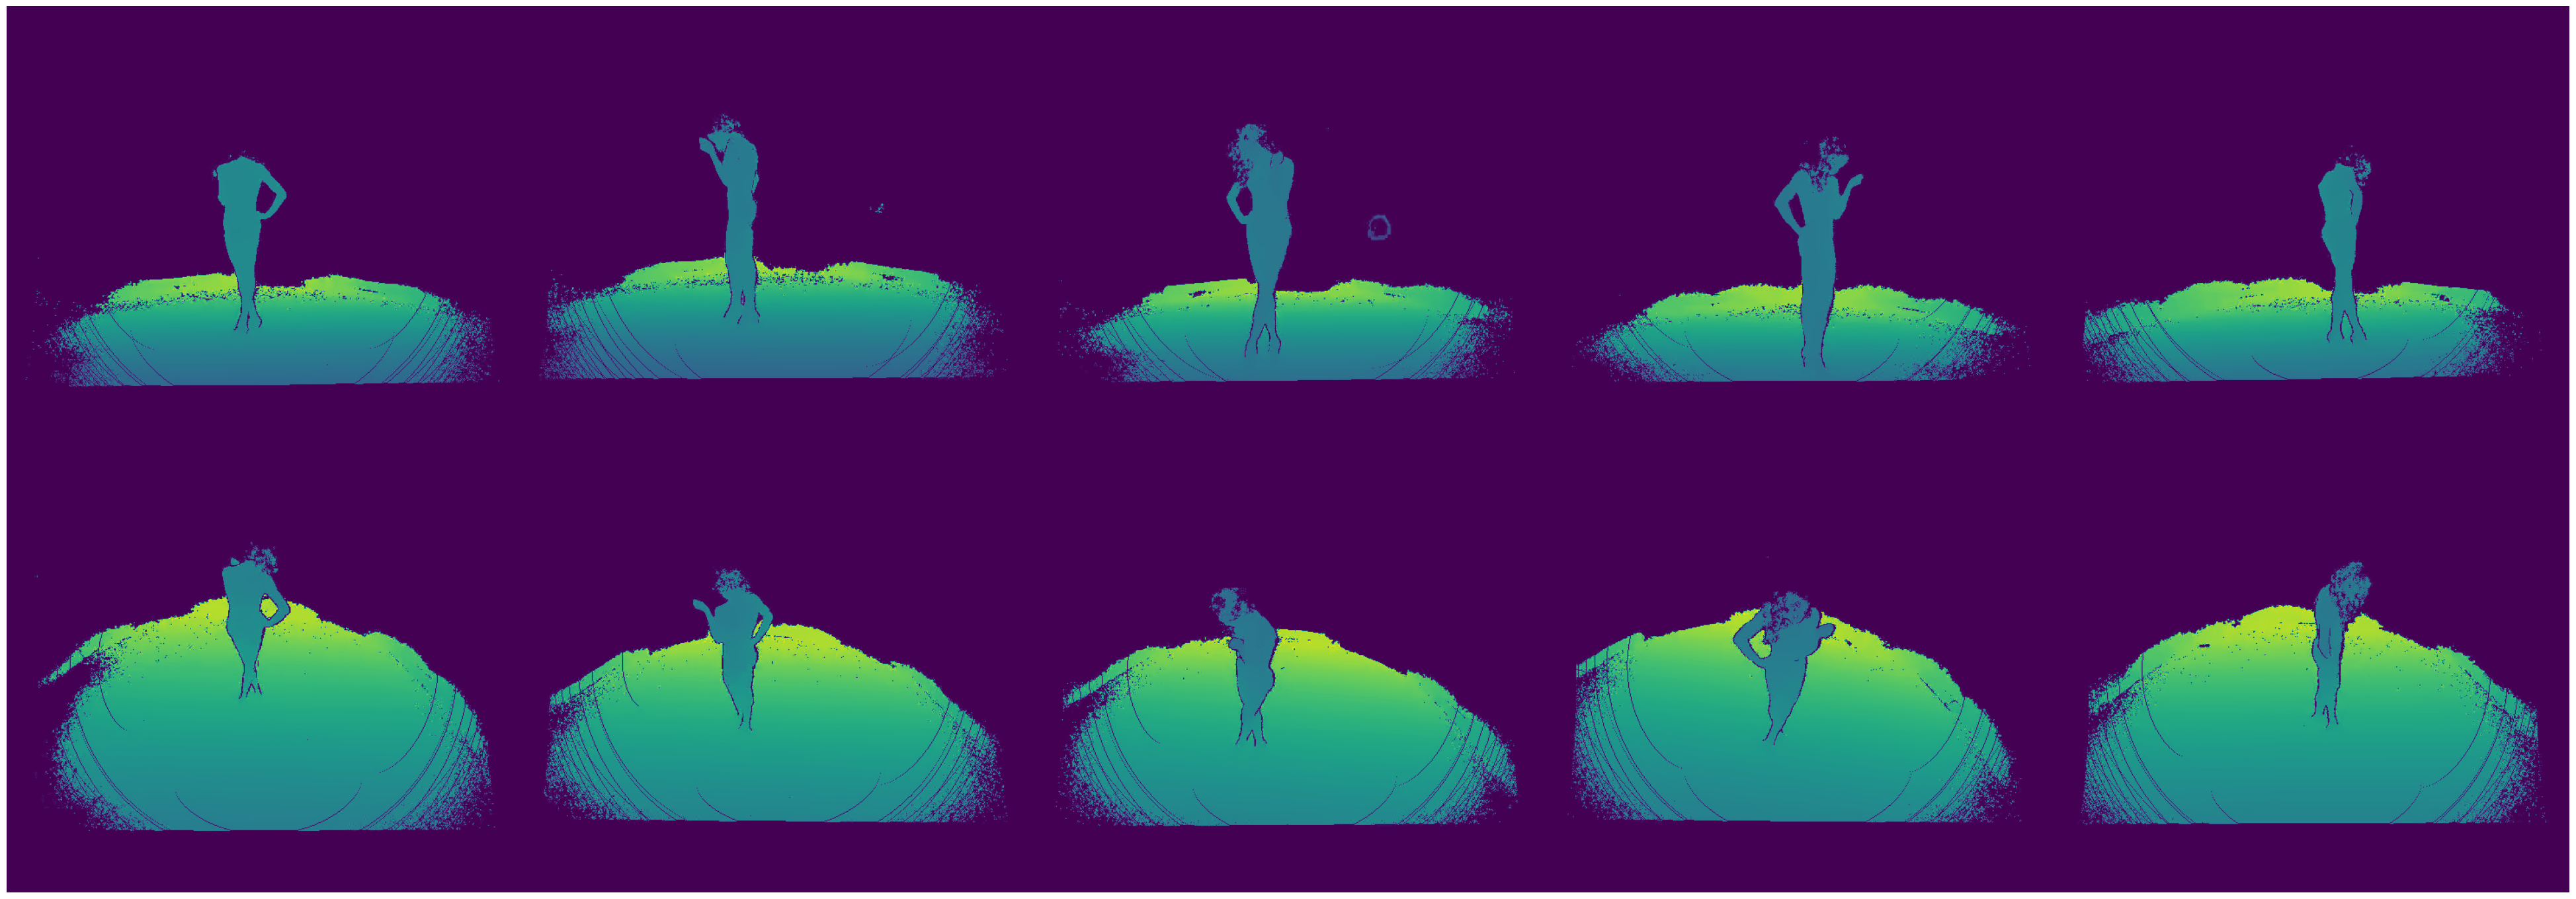

In [5]:
import cv2 as cv
views = []    
temp = []
for i in range(10):
	# img = cv.imread("/home/lei/data/pipeline/server_standalone/160317_moonbaby1_clean/nvenc_10k_20k_d_yuv16_scaled/100_depth_{}.png".format(i), cv.IMREAD_ANYDEPTH)
 
	img = cv.imread("/home/lei/data/pipeline/client_standalone/160317_moonbaby1_scaled/depth_nvenc_2m_d_yuv16/100_depth_{}.png".format(i), cv.IMREAD_ANYDEPTH)
	temp.append(img)
	if i % 5 == 4:
		views.append(temp)
		temp = []

# offset_x = 20
# offset_y = 20
# hqr = 82
# wqr = 82

views_concat_yuv16 = cv.vconcat([cv.hconcat(v_list) for v_list in views])
# views_concat_yuv16[offset_y:offset_y+hqr, offset_x:offset_x+wqr] = 0
print(views_concat_yuv16.shape)
print(views_concat_yuv16.dtype)
plt.figure(figsize = (50,100))
plt.imshow(views_concat_yuv16)
plt.axis('off')
plt.show()

(1024, 2960)
uint16


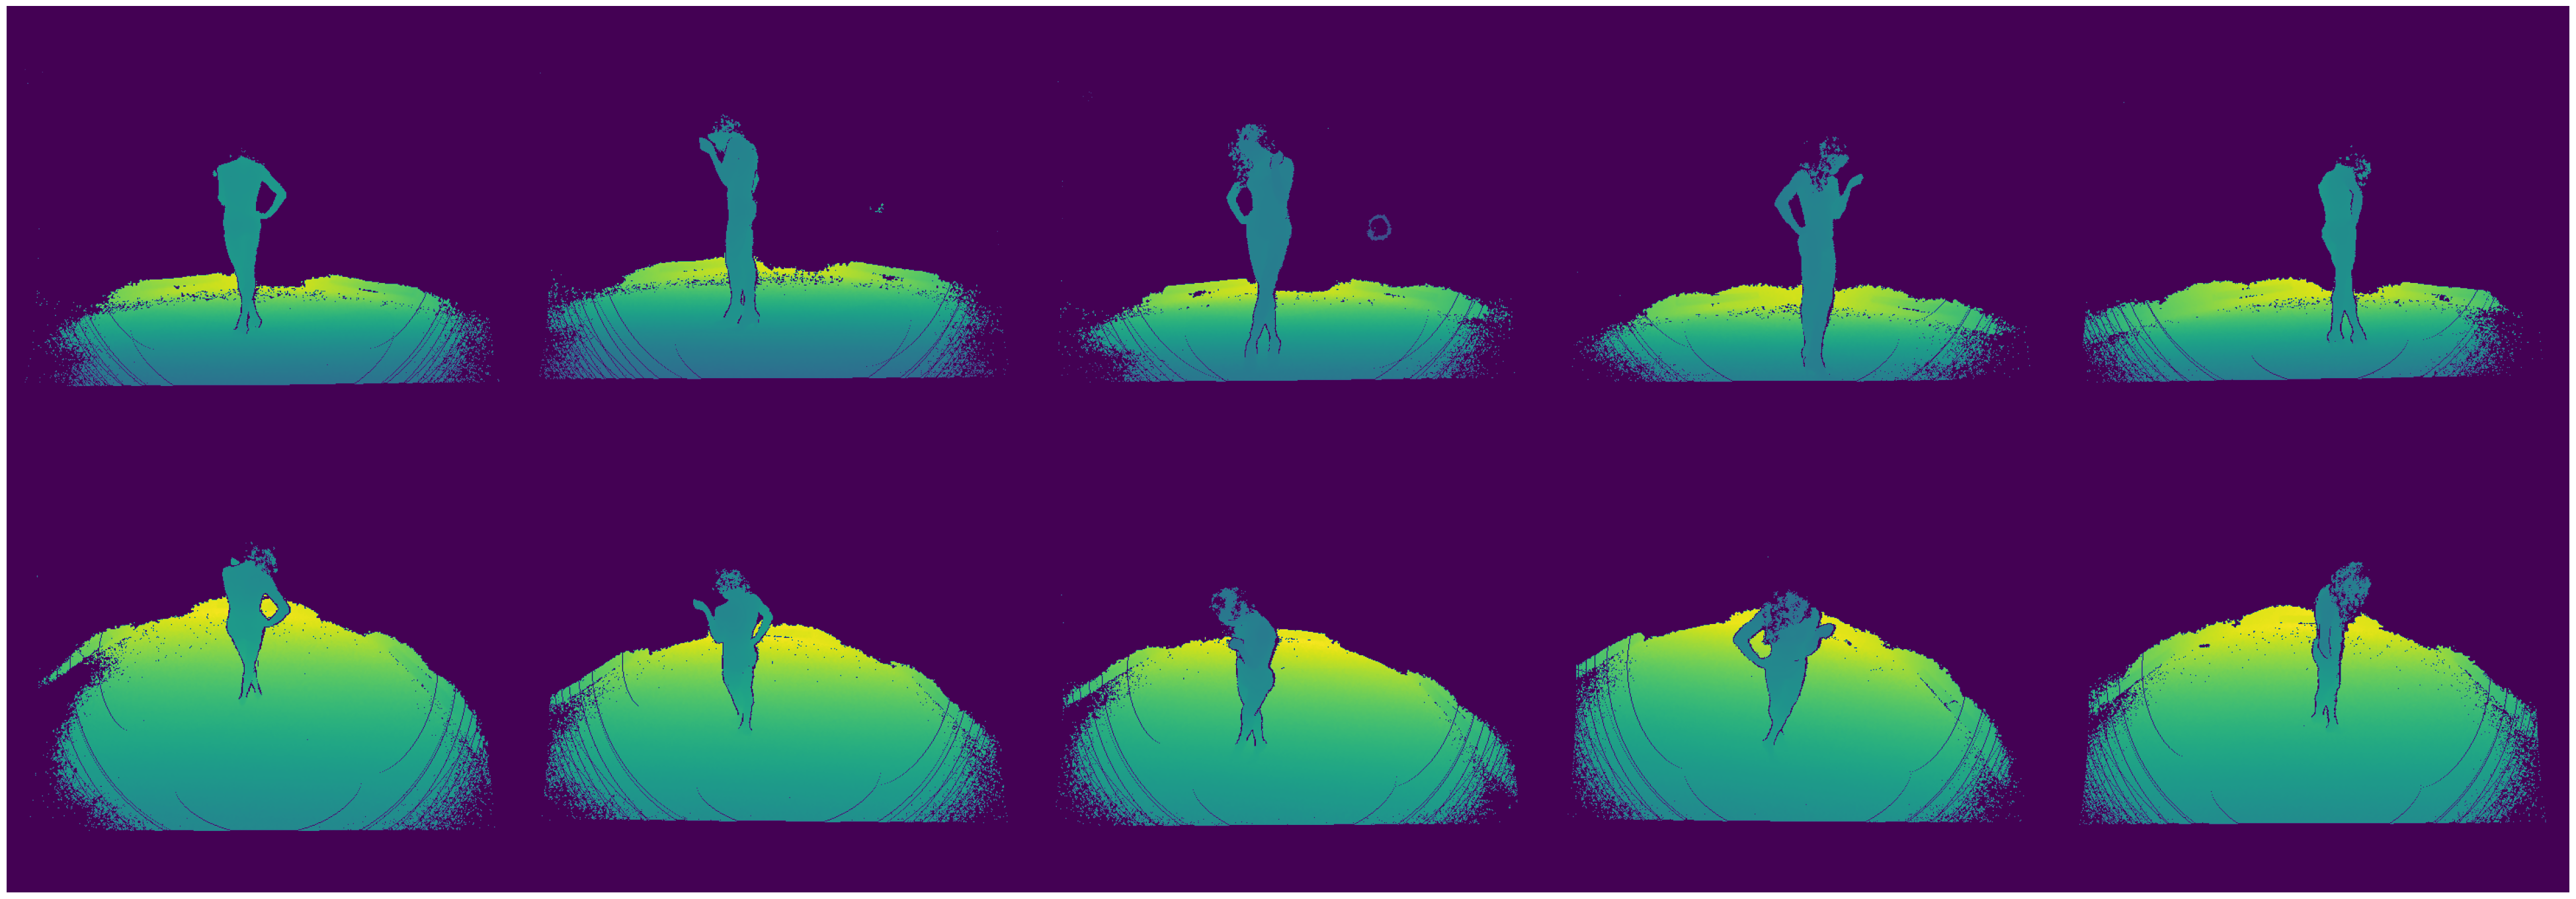

In [6]:
views = []    
temp = []
for i in range(10):
	img = cv2.imread("/home/lei/data/KinectStream/panoptic_captures/160317_moonbaby1_scaled/depth/100_depth_{}.png".format(i), cv2.IMREAD_ANYDEPTH)
	temp.append(img)
	if i % 5 == 4:
		views.append(temp)
		temp = []

views_concat_gt = cv.vconcat([cv.hconcat(v_list) for v_list in views])
print(views_concat_gt.shape)
print(views_concat_gt.dtype)
plt.figure(figsize = (50,100))
plt.imshow(views_concat_gt)
plt.axis('off')
plt.show()

In [7]:
from sklearn.metrics import mean_squared_error
import math

print("GT MAX depth", np.max(views_concat_gt))
print("YUV MAX depth", np.max(views_concat_yuv16))

rmse = math.sqrt(mean_squared_error(views_concat_gt, views_concat_yuv16))
print("RMSE: ", rmse)


GT MAX depth 5498
YUV MAX depth 5994
RMSE:  43.03150486885135


In [1]:
# Move color, depth, binary images to sepearte folders

import shutil
import os
import glob

def move_files(src, dst, wildcard):
	if not os.path.exists(dst):
		os.makedirs(dst)
	for file in glob.glob(os.path.join(src, wildcard)):
		shutil.move(file, dst)

src = "/home/lei/data/KinectStream/panoptic_captures/160317_moonbaby1/"

move_files(src, os.path.join(src, "color"), "*_color*.png")
move_files(src, os.path.join(src, "depth"), "*_depth*.png")
move_files(src, os.path.join(src, "binary_mask"), "*_binary_mask*.png")

In [ ]:
h, w, d = 524, 612, 3
yuv444 = np.zeros((h, w, d), dtype=np.uint16)
w_offset = 1
h_offset = 2
s_dim = 100
yuv444[h_offset:h_offset+s_dim, w_offset:w_offset+s_dim, 0] = 5000

print("Shape: ", yuv444.shape)
print("Dtype: ", yuv444.dtype)
print("Max: {}, Min: {}".format(np.max(yuv444), np.min(yuv444)))
yuv444_flat = yuv444.flatten()
print("Flattended shape: ", yuv444_flat.shape)

plt.imshow(yuv444[:,:,0])

In [ ]:
y_flat = yuv444[:, :, 0].flatten()
u_flat = yuv444[:, :, 1].flatten()
v_flat = yuv444[:, :, 2].flatten()

yuv444_flat = np.concatenate((y_flat, u_flat, v_flat), axis=0)

In [ ]:
yuv444_flat.shape

In [ ]:
a = np.array([1, 2, 3], dtype=np.uint16)
b = np.array([4, 5, 6], dtype=np.uint16)
c = np.array([7, 8, 9], dtype=np.uint16)
d = np.concatenate((a, b, c))


In [ ]:
a = np.random.randint(5, 20, (10, 5))
print(a)
a_flat = a.flatten()
print(a_flat)
buf = a_flat.tobytes()

In [ ]:
print(int.from_bytes(buf[64:72], "little"))

In [14]:
from scipy import stats

a = np.array([[3, 0, 3, 7],
              [3, 2, 6, 2],
              [1, 7, 2, 8],
              [3, 0, 6, 1],
              [3, 2, 5, 5]])
mode, _ = stats.mode(a, axis=None)
mode[0]

3

In [ ]:
views = []    
temp = []
for i in range(10):
	img = cv2.imread("/home/lei/data/KinectStream/panoptic_captures/160317_moonbaby1_scaled/depth/100_depth_{}.png".format(i), cv2.IMREAD_ANYDEPTH)
	temp.append(img)
	if i % 5 == 4:
		views.append(temp)
		temp = []

views_concat_gt = cv.vconcat([cv.hconcat(v_list) for v_list in views])
print(views_concat_gt.shape)
print(views_concat_gt.dtype)
plt.figure(figsize = (50,100))
plt.imshow(views_concat_gt)
plt.axis('off')
plt.show()

In [6]:
f_no_cull = pd.read_csv("/home/lei/data/pipeline/server_tiled/pipeline_new/frustum_size_wo_cull.txt")
f_kpcull = pd.read_csv("/home/lei/data/pipeline/server_tiled/pipeline_new/frustum_size_kpcull.txt")
f_pcull = pd.read_csv("/home/lei/data/pipeline/server_tiled/pipeline_new/frustum_size_pcull.txt")

f_kpcull3 = pd.read_csv("/home/lei/data/pipeline/server_tiled/pipeline_new/frustum_size_kpcull3.txt")
f_kpcull5 = pd.read_csv("/home/lei/data/pipeline/server_tiled/pipeline_new/frustum_size_kpcull5.txt")
f_kpcull10 = pd.read_csv("/home/lei/data/pipeline/server_tiled/pipeline_new/frustum_size_kpcull10.txt")

In [7]:
f_no_cull_mean = np.mean(f_no_cull["Size"])
f_kpcull_mean = np.mean(f_kpcull["Size"])
f_pcull_mean = np.mean(f_pcull["Size"])
f_kpcull3_mean = np.mean(f_kpcull3["Size"])
f_kpcull5_mean = np.mean(f_kpcull5["Size"])
f_kpcull10_mean = np.mean(f_kpcull10["Size"])

print("P Cull Savings:", f_pcull_mean/f_no_cull_mean)
print("KP Cull Savings: ", f_kpcull_mean/f_no_cull_mean)
print("KP Cull 3 Savings: ", f_kpcull3_mean/f_no_cull_mean)
print("KP Cull 5 Savings: ", f_kpcull5_mean/f_no_cull_mean)
print("KP Cull 10 Savings: ", f_kpcull10_mean/f_no_cull_mean)
print()

P Cull Savings: 0.26864873711837106
KP Cull Savings:  0.8694245047224756
KP Cull 3 Savings:  0.3347714436325416
KP Cull 5 Savings:  0.3321554936985548
KP Cull 10 Savings:  0.32967969918536266



(-0.5, 591.5, 511.5, -0.5)

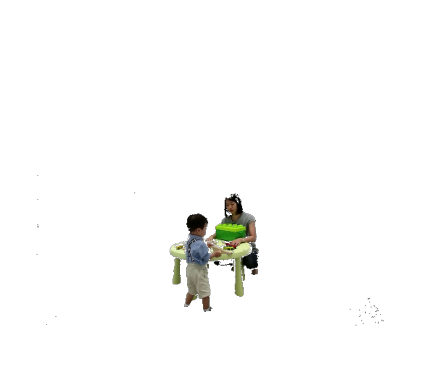

In [14]:
path = "/datassd/KinectStream/panoptic_data/color/"
cimg = cv2.imread(os.path.join(path, "2000_color_0.png"), cv2.IMREAD_UNCHANGED)
cimg = cv2.cvtColor(cimg, cv2.COLOR_BGRA2RGBA)
plt.imshow(cimg)
plt.axis('off')